## Task 1: A classification example: fetal heart condition diagnosis

#### Step 1

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
  
# Read the CSV file.
data = pd.read_csv("/Users/laqfire/code/Applied_ML/lab1/CTG.csv", skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [36]:
X.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
658,130.0,1.0,0.0,3.0,0.0,0.0,0.0,24.0,1.2,12.0,...,35.0,120.0,155.0,1.0,0.0,134.0,133.0,135.0,1.0,0.0
1734,134.0,9.0,1.0,8.0,5.0,0.0,0.0,59.0,1.2,0.0,...,109.0,80.0,189.0,6.0,0.0,150.0,146.0,150.0,33.0,0.0
1226,125.0,1.0,0.0,4.0,0.0,0.0,0.0,43.0,0.7,31.0,...,21.0,120.0,141.0,0.0,0.0,131.0,130.0,132.0,1.0,0.0
1808,143.0,0.0,0.0,1.0,0.0,0.0,0.0,69.0,0.3,6.0,...,27.0,132.0,159.0,1.0,0.0,145.0,144.0,146.0,1.0,0.0
825,152.0,0.0,0.0,4.0,0.0,0.0,0.0,62.0,0.4,59.0,...,25.0,136.0,161.0,0.0,0.0,159.0,156.0,158.0,1.0,1.0


#### Step 2

In [37]:

from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')
from sklearn.model_selection import cross_val_score

import numpy as np
scores = cross_val_score(clf, Xtrain, Ytrain)
print("Scores:", scores)
print("Mean score:", np.mean(scores))

Scores: [0.78235294 0.78235294 0.77941176 0.77941176 0.77941176]
Mean score: 0.7805882352941176


#### Step 3

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')


# create dictionary of classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Perceptron': Perceptron(),
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Linear SVC': LinearSVC(),
    'Neural Network': MLPClassifier(random_state=0, max_iter=2000)
}


# compute the cross-validation accuuracy
# 5-fold instead of 3-fold cross-validation
# Accuracy as evaluation metric
for name, clf in classifiers.items():
    score = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='accuracy').mean()
    print(f'{name}: {score}')

Decision Tree: 0.9188235294117646
Random Forest: 0.9400000000000001
Gradient Boosting: 0.9488235294117647
Perceptron: 0.825294117647059
Logistic Regression: 0.8988235294117647
Linear SVC: 0.8952941176470588
Neural Network: 0.8847058823529412


#### Step 4

As we can see above, Gradient Boosting has the highest accuary.

In [39]:
from sklearn.metrics import accuracy_score
  
gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, Ytrain)
Yguess = gbc.predict(Xtest)
print(f"Accuracy: {accuracy_score(Ytest, Yguess)}")


Accuracy: 0.9295774647887324


## Task 2: Decision trees for classification

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
clf = DecisionTreeClassifier(max_depth = 1)
clf.fit(Xtrain, Ytrain);
from sklearn.model_selection import cross_val_score

cross_val_score(clf, Xtrain, Ytrain, cv=5).mean()

np.float64(0.8164705882352941)

In [41]:
class DecisionTreeLeaf:

    def __init__(self, value):
            self.value = value
    
       # This method computes the prediction for this leaf node. This will just return a constant value.\n",
    def predict(self, x):
           return self.value
    
        # Utility function to draw a tree visually using graphviz.\n",
    def draw_tree(self, graph, node_counter, names):
           node_id = str(node_counter)
           val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
           graph.node(node_id, val_str, style='filled')
           return node_counter+1, node_id

    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
               return self.value == other.value
        else:
               return False
        
    def to_str(self, indent, lines, names):
           val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
           lines.append(' '*indent + val_str)

In [42]:
class DecisionTreeBranch:
    
        def __init__(self, feature, threshold, low_subtree, high_subtree):
            self.feature = feature
            self.threshold = threshold
            self.low_subtree = low_subtree
            self.high_subtree = high_subtree
    
        # For a branch node, we compute the prediction by first considering the feature, and then \n",
        # calling the upper or lower subtree, depending on whether the feature is or isn't greater\n",
        # than the threshold.\n",
        def predict(self, x):
            if x[self.feature] <= self.threshold:
                return self.low_subtree.predict(x)
            else:
                return self.high_subtree.predict(x)
    
        # Utility function to draw a tree visually using graphviz.\n",
        def draw_tree(self, graph, node_counter, names):
            node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
            node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
            node_id = str(node_counter)
            fname = f'F{self.feature}' if names is None else names[self.feature]
            lbl = f'{fname} > {self.threshold:.4g}?'
            graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
            graph.edge(node_id, low_id, 'False')
            graph.edge(node_id, high_id, 'True')
            return node_counter+1, node_id
            
        def to_str(self, indent, lines, names):
            pad = ' '*indent
            fname = f'F{self.feature}' if names is None else names[self.feature]
            lines.append(pad + f'{fname} <= {self.threshold:.3g}?')
            lines.append(pad + '  True =>')
            self.low_subtree.to_str(indent+4, lines, names)
            lines.append(pad + '  False =>')
            self.high_subtree.to_str(indent+4, lines, names)
            

In [43]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod
    
class DecisionTree(ABC, BaseEstimator):
    
        def __init__(self, max_depth):
            super().__init__()
            self.max_depth = max_depth
            
        # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that\n",
        # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method\n",
        # called make_tree (see below).\n",
        def fit(self, X, Y):
            if isinstance(X, pd.DataFrame):
                self.names = X.columns
                X = X.to_numpy()
            elif isinstance(X, list):
                self.names = None
                X = np.array(X)
            else:
                self.names = None
            Y = np.array(Y)        
            self.root = self.make_tree(X, Y, self.max_depth)
            
        def draw_tree(self):
            graph = Digraph()
            self.root.draw_tree(graph, 0, self.names)
            return graph
    
        # By scikit-learn convention, the method *predict* computes the classification or regression output\n",
        # for a set of instances.\n",
        # To implement it, we call a separate method that carries out the prediction for one instance.\n",
        def predict(self, X):
            if isinstance(X, pd.DataFrame):
                X = X.to_numpy()
            return [self.predict_one(x) for x in X]
    
        # Predicting the output for one instance.\n",
        def predict_one(self, x):
            return self.root.predict(x)       
    
        # This is the recursive training \n",
        def make_tree(self, X, Y, max_depth):
    
            # We start by computing the default value that will be used if we'll return a leaf node.\n",
            # For classifiers, this will be the most common value in Y.\n",
            default_value = self.get_default_value(Y)
    
            # First the two base cases in the recursion: is the training set completely\n",
            # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.\n",
    
            # If we have reached the maximum depth, return a leaf with the majority value.\n",
            if max_depth == 0:
                return DecisionTreeLeaf(default_value)
    
            # If all the instances in the remaining training set have the same output value,\n",
            # return a leaf with this value.\n",
            if self.is_homogeneous(Y):
                return DecisionTreeLeaf(default_value)

            # Select the \"most useful\" feature and split threshold. To rank the \"usefulness\" of features,\n",
            # we use one of the classification or regression criteria.\n",
            # For each feature, we call best_split (defined in a subclass). We then maximize over the features.\n",
            n_features = X.shape[1]
            
            _, best_feature, best_threshold = max(self.best_split(X, Y, feature) 
                    for feature in range(n_features))
            
            if best_feature is None:
                return DecisionTreeLeaf(default_value)
    
            # Split the training set into subgroups, based on whether the selected feature is greater than\n",
            # the threshold or not\n",
            X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)
    
            # Build the subtrees using a recursive call. Each subtree is associated\n",
            # with a value of the feature.\n",
            low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
            high_subtree = self.make_tree(X_high, Y_high, max_depth-1)
    
            if low_subtree == high_subtree:
                return low_subtree
    
            # Return a decision tree branch containing the result.\n",
            return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
        
        # Utility method that splits the data into the \"upper\" and \"lower\" part, based on a feature\n",
        # and a threshold.\n",
        def split_by_feature(self, X, Y, feature, threshold):
            low = X[:,feature] <= threshold
            high = ~low
            return X[low], X[high], Y[low], Y[high]
        
        def __str__(self):
            lines = []
            self.root.to_str(0, lines, self.names)
            return '\\n'.join(lines)
        
        # The following three methods need to be implemented by the classification and regression subclasses.\n",
        
        @abstractmethod
        def get_default_value(self, Y):
            pass
    
        @abstractmethod
        def is_homogeneous(self, Y):
            pass
    
        @abstractmethod
        def best_split(self, X, Y, feature):
            pass

In [44]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

In [45]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)


In [46]:
# try different max_depth value
depths = range(1, 30)
scores = []

for depth in depths:
   clf = TreeClassifier(max_depth=depth)
   score = cross_val_score(clf, Xtrain, Ytrain, cv=5).mean()
   scores.append(score)

# find the best
best_depth = depths[np.argmax(scores)]

# evaluate the classifier
best_clf = TreeClassifier(max_depth=best_depth)
best_clf.fit(Xtrain, Ytrain)
test_score = best_clf.score(Xtest, Ytest)

print(f'Best depth: {best_depth}')
print(f'Test accuracy: {test_score}')

Best depth: 13
Test accuracy: 0.8732394366197183


draw a tree for illustration

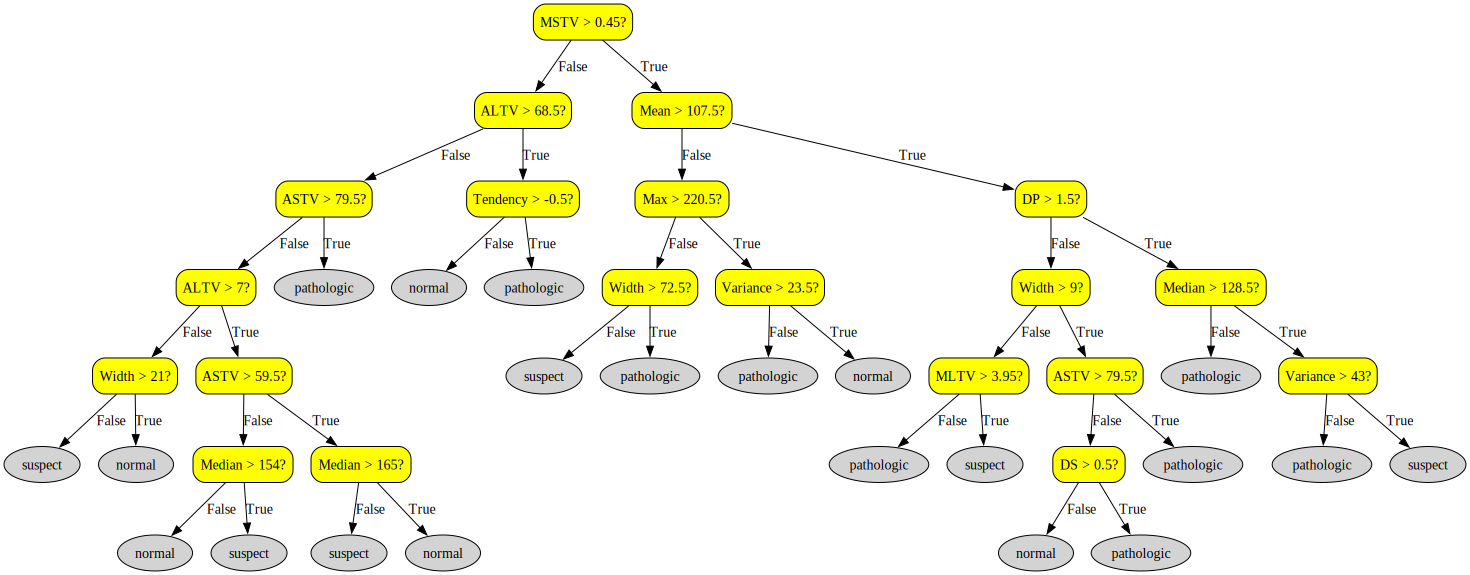

In [47]:
cls = TreeClassifier(max_depth=6)
cls.fit(Xtrain, Ytrain)
cls.draw_tree()

## Task 3: A regression example: predicting apartment prices

#### Step 1: Data Munging

Read the `sberbank.csv` file, select specific columns, shuffle the data, seperate input matrix `X` and ouput vector `y`, and then do the test-training split. 

The following code is quoted from [the instructions](https://www.cse.chalmers.se/~richajo/dit866/assignments/a1/assignment1.html).

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Read the CSV file using Pandas.
alldata = pd.read_csv("sberbank.csv")

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 7 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

#### Step 2: Train and evaluate different regression models

First, we perform cross validtion on the training set for all the regressors, and select the model with highest score to train on the whole training set and evaluate on the held-out test set.

The models used are shown in the code.

In [49]:

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

models = {
    "DummyRegressor": DummyRegressor(),
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=1.0, max_iter=1000, tol=0.0001, random_state=114514),
    "Ridge": Ridge(
            alpha=1.0, fit_intercept=True, solver='auto', 
            max_iter=None, tol=0.001, random_state=42
        ),
    "RandomForestRegressor": RandomForestRegressor(
            n_estimators=100, 
            max_depth=None, min_samples_split=2, min_samples_leaf=1, 
            random_state=42, max_features= 1 / 3
        ),
    "GradientBoostingRegressor": GradientBoostingRegressor(
            n_estimators=100, learning_rate=0.1, max_depth=3, 
            min_samples_split=2, min_samples_leaf=1, random_state=42
        ),
    "DecisionTreeRegressor": DecisionTreeRegressor(
            max_depth=None, min_samples_split=2, 
            min_samples_leaf=1, random_state=42, ccp_alpha=0.01
        ),
    "MLPRegressor": MLPRegressor(
            random_state=198 
        ),
}

#Preform cross validation for all models on the training set
#Print their scores
for name, regr_model in models.items():
    score = cross_val_score(regr_model, Xtrain, Ytrain, scoring="neg_mean_squared_error").mean()
    print(f"Model: {name}; Score: {score}")
    

Model: DummyRegressor; Score: -0.38925247260237567
Model: LinearRegression; Score: -0.3013986588767176
Model: Lasso; Score: -0.3010470671748872
Model: Ridge; Score: -0.30139784232179745
Model: RandomForestRegressor; Score: -0.27988745119594965
Model: GradientBoostingRegressor; Score: -0.2645272118267597
Model: DecisionTreeRegressor; Score: -0.3115473038894633
Model: MLPRegressor; Score: -11.144804540767561


Clearly, `GradientBoostingRegressor` achieved highest score in cross validation.

Finally, train it on the full training set and evaluate on the held-out test set:

In [50]:
regr_model = models["GradientBoostingRegressor"]
regr_model.fit(Xtrain, Ytrain)
mse = mean_squared_error(Ytest, regr_model.predict(Xtest))
print(f"Model: GradientBoostingRegressor， MSE: {mse}")

Model: GradientBoostingRegressor， MSE: 0.2713747983891566


### Task 4: Decision trees for regression

#### 1) Small Dataset Training

We first train a tree regressor on a small dataset to see how it works. We will use the Russian dataset for training later.

In [51]:
# Importing libraries
import numpy as np
import pandas as pd
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin

In [52]:
from sklearn.base import RegressorMixin

class TreeRegressor(DecisionTree, RegressorMixin):
    def __init__(self, max_depth=10, criterion='variance_reduction'):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):

        super().fit(X, Y)
   # Select a default value that is going to be used if we decide to make a leaf.
   # We will select the most common value.
    def get_default_value(self, Y):

        return np.mean(Y)

    # Checks whether a set of output values is homogeneous. In the classification case,
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        variance_threshold = 1e-6
        return np.var(Y) < variance_threshold

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature, tot_var=None):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = X[sorted_indices, feature]
        Y_sorted = Y[sorted_indices]
        tot_var = np.var(Y) * len(Y)

        n = len(Y)
        if n <= 1:
            return -np.inf, None, None
        total_variance = np.var(Y) * n

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        #low_distr = Counter()
        #high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        best_split_point = None

        # Initialize sum values for variance computation
        partial_low_squared_sum = 0
        partial_low_sum_squared = 0
        partial_high_squared_sum = np.sum(Y)
        partial_high_sum_squared = np.sum(Y ** 2)
     # Go through all the positions (excluding the last position).
                # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            partial_low_squared_sum += y_i**2
            partial_low_sum_squared += y_i

            partial_high_squared_sum -= y_i**2
            partial_high_sum_squared -= y_i

            n_low = i + 1
            n_high = n - n_low
            low_var = partial_low_squared_sum / n_low - partial_low_sum_squared**2 / (n_low**2)
            high_var = partial_high_squared_sum / n_high - partial_high_sum_squared**2 / (n_high**2)

            # Update the frequency tables.
            #low_distr[y_i] += 1
            #high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = tot_var - (n_high * high_var + n_low * low_var) / n

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

Sanity check

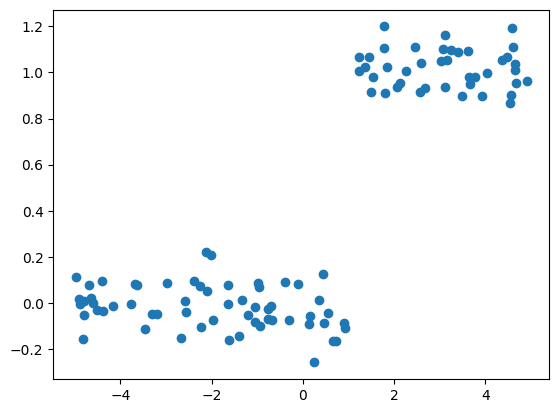

In [53]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y
X, Y = make_some_data(100)
plt.scatter(X, Y)
plt.show()

It generated a small number of training examples for a simple regression task with one input variable. The output figure is similar to the one in the assignment.

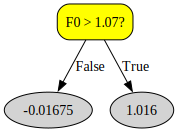

In [54]:
clf = TreeRegressor(max_depth=1)
clf.fit(X, Y)
clf.draw_tree()

After sanity check and small dataset testing(with max_depth=1), we found out that it runs well and can perform well on the small dataset. Now we can proceed to the Russian housing prices prediction.

For the data-generating function, the decision tree would be like a binary segmentation based on whether "x > 1". We hope the decision tree with a depth of 1 would be sufficient to describe this data. The tree would have a single split point at x = 1, creating two leaf nodes, one representing the average value of the data where x ≤ 1 and the other where x > 1, just like the figure above.

A tree depth of 1 was selected based on the simplicity of the data-generating function. The resulting tree successfully splits the data at the optimal threshold (e.g., x = 1.027). The leaf nodes represent the average values of the two partitions, which matches the expected structure of the function. The result makes sense as it aligns with the binary nature of the data.

It would cause  overfitting if the data is too complex and the tree is too deep. And we are going to simulate and show the data in the following sections.


#### 2) Russian Housing Prices Prediction

In this part we will use the Sberbank dataset to predict the apartment prices in Russia. We will use the decision tree regression algorithm to predict the prices. Before we start, we need to preprocess the data.

In [55]:
# Data preprocessing
import numpy as np
import pandas as pd
# Read the CSV file using Pandas.
alldata = pd.read_csv("sberbank.csv")

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 7 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
m1 = DummyRegressor()
cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([0.0004921 , 0.00033832, 0.0003252 , 0.00032091, 0.0003171 ]),
 'score_time': array([0.00020099, 0.00015187, 0.00014687, 0.00014281, 0.00014091]),
 'test_score': array([-0.39897319, -0.37113485, -0.38083108, -0.39057156, -0.40475168])}

Step 1. Implementing the regression model

In [56]:
class TreeRegressor(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=10):
        super().__init__(max_depth)

    def fit(self, X, Y):
        super().fit(X, Y)

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        return np.mean(Y)

    # Checks whether a set of output values is homogeneous. In the classification case,
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        variance_threshold = 0.01
        return np.var(Y) < variance_threshold

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n_row = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_part = []
        high_part = Y_sorted.copy()

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n_row-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the frequency tables.
            low_part.append(y_i)
            high_part.pop(0)

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            s = low_part + high_part
            n = n_row
            score = np.var(s) - ((i + 1) * np.var(low_part) + (n_row - i - 1) * np.var(high_part)) / n
            #score = variance_reduction(i+1, low_part, n_row-i-1, high_part)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

Step 2. Sanity check

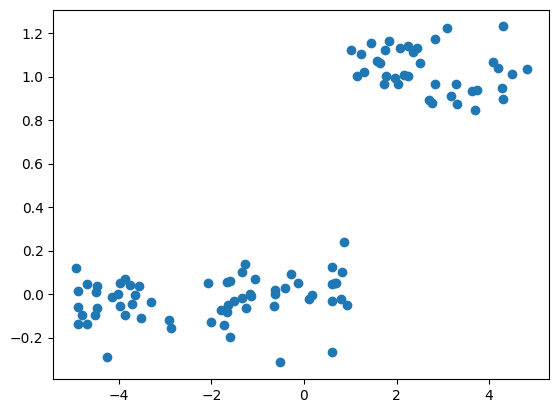

In [57]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y
X, Y = make_some_data(100)
plt.scatter(X, Y)
plt.show()

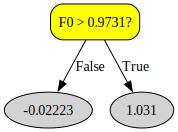

In [58]:
# Small dataset training
clf = TreeRegressor(max_depth=1)
clf.fit(X, Y)
clf.draw_tree()

Step 3. Predicting apartment prices using decision tree regression

In [59]:
Rus = TreeRegressor(max_depth=5)
Rus.fit(Xtrain, Ytrain)
Rus.score(Xtest, Ytest)

0.27799386048394825

For this prediction, as we studied before, we knew there would be a difference in performance if we choose different depths. Thus, we chose 5 as the value of max_depth to test. The evaluation score is 0.28. This score indicates the proportion of variance explained by the model on the test set, which reflects the predictive performance of the decision tree.

Step 4. Underfitting and overfitting

Depth | Training Score | Testing Score
-------------------------------------
0     | 0.0000         | -0.0001       
1     | 0.1614         | 0.1534        
2     | 0.2280         | 0.2263        
3     | 0.2566         | 0.2505        
4     | 0.2786         | 0.2723        
5     | 0.2955         | 0.2780        
6     | 0.3156         | 0.2893        
7     | 0.3389         | 0.2783        
8     | 0.3652         | 0.2551        
9     | 0.3906         | 0.2364        
10    | 0.4249         | 0.2189        
11    | 0.4641         | 0.1904        
12    | 0.5037         | 0.1454        


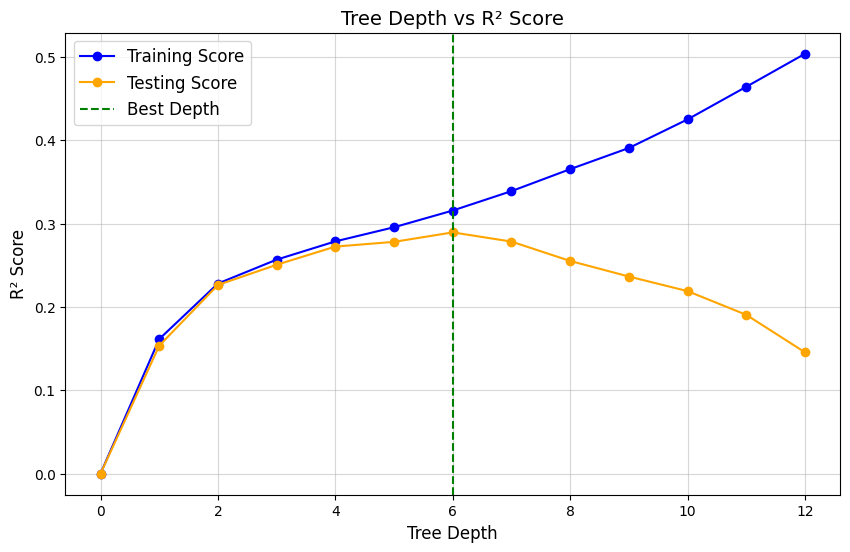


Best cooperation:
Best depth: 6
Max test score: 0.2893


In [60]:
from sklearn.metrics import r2_score

def test_tree_regressor_depth(X_train, X_test, Y_train, Y_test, max_depth=13):

    depths = np.arange(0, max_depth)
    train_scores = []
    test_scores = []

    print("Depth | Training Score | Testing Score")
    print("-------------------------------------")

    for depth in depths:
        rus = TreeRegressor(max_depth=depth)

        rus.fit(X_train.values, Y_train.values)

        Y_train_pred = rus.predict(X_train.values)
        Y_test_pred = rus.predict(X_test.values)

        train_score = r2_score(Y_train.values, Y_train_pred)
        test_score = r2_score(Y_test.values, Y_test_pred)

        train_scores.append(train_score)
        test_scores.append(test_score)

        print(f"{depth:<5} | {train_score:<14.4f} | {test_score:<14.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_scores, label='Training Score', marker='o', color='blue')
    plt.plot(depths, test_scores, label='Testing Score', marker='o', color='orange')
    plt.axvline(x=np.argmax(test_scores), color='green', linestyle='--', label='Best Depth')
    plt.title('Tree Depth vs R² Score', fontsize=14)
    plt.xlabel('Tree Depth', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

    best_depth = np.argmax(test_scores)
    print("\nBest cooperation:")
    print(f"Best depth: {best_depth}")
    print(f"Max test score: {max(test_scores):.4f}")

test_tree_regressor_depth(Xtrain, Xtest, Ytrain, Ytest, max_depth=13)



In the final underfitting and overfitting analysis, the blue curve represents the training score and the orange curve represents the testing score. The green line represents the best depth that achieves the highest testing score. For the blue curve, the score rises as the depth increases, indicating that the model is overfitting the training data. For the orange curve, the score increases as the depth increases, however, when reaching a pole, the score starts to decrease, indicating that the model is starting to overfit the test data. And among the range of the assignment, the best depth is 6 after comparing to each other. the Max test score is 0.2893, which is the best score we can get. The chart shows the total depths we tried and the corresponding scores also with the figure above.